# A Methodology for Machine Learning Analysis of Space-Exposed Murine Liver (Transcriptomics)

The purpose of this analysis notebook is to provide the necessary code to perform our analysis and generate figures necessary for our the publication *Spaced Out Data No More: Genomic Harmonization Meets Machine Learning in Murine Livers*. 

- Notebook Author: Hari Ilangovan


|Version History | Date | 
|----------| ----- |
|v0| 12/10/2022 | 
|v1 | 11/2/2023 | 


Publication Authorship:
- Hari Ilangovan<sup>1</sup>
- Prachi Kothiyal<sup>2</sup>
- Katherine A. Hoadley<sup>3</sup>
- Robin Elgart<sup>4</sup>
- Greg Eley<sup>2</sup>
- Parastou Eslami<sup>5</sup>

<sup>1</sup> Science Applications International Corporation (SAIC), Reston, VA 20190, USA
<sup>2</sup>Scimentis LLC, Statham, GA 30666, USA
<sup>3</sup>Department of Genetics, Computational Medicine Program, Lineberger Comprehensive Cancer Center, University of North Caroline at Chapel Hill, Chapel Hill, NC 27599, USA
<sup>4</sup>University of Houston, Houston, TX 77204, USA
<sup>5</sup>Universal Artificial Intelligence Inc, Boston, MA 02130, USA

# Quick links
- Gene Set Enrichment Analysis
  - [GSEA (ML Models)](#Gene-Set-Enrichment-Analysis-for-RF-LDA-SVM)
  - [GSEA (RR Missions)](#Gene-Set-Enrichment-Analysis-for-RR-Missions-(Fold-Change))
- Genes Contributing to Gene Ontology Gene Signatures 
  - [SVM GO BPs](#SVM---Contributing-Genes-to-GO-BP-Analysis)
- Relaxed GSEA Analysis to Compare Directionality of Normalized Enrichment Scores
  - [Relaxed GSEA Analysis](#SVM-to-RR-Mission-GO-BP-Comparison)
- Mus Musculus Strain Reference Analysis
  - [Genetic Background Lookup](#Genetic-Backround-Comparison)
- [Gene Ranking Overlaps](#MRMR-Gene-Ranking-Overlaps-with-SVM-LDA-and-RF)
- [Single & Merged Only - Contributing Genes to GO BPs](#RR---Single-&-Merged-Study-Only-Contributing-Genes-to-GO-BPs)

In [1]:
library(dplyr)
library(patchwork)
library(tidyverse)
library(clusterProfiler)
organism="org.Mm.eg.db"
library(organism, character.only = TRUE)
library(rrvgo)
library(data.table)
library(nVennR)
library(rjson)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.2     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMIC

In [2]:
generate_flat_files = TRUE

In [3]:
setwd('./../scripts/')

# Gene Set Enrichment Analysis for RF LDA SVM

[Quick Links](#Quick-links)

The following code block is used to generate GSEA results using the `clusterProfiler` package.

We run the Gene Set Enrichment Analysis algorithm on the SVM coefficients generated from the `Python Mouse Liver Manuscript.ipynb` and saved into the `./data/coefficient_results/svm_importances.csv` file. 

In [222]:
svm_scores <- read.table('./data/coefficient_results/svm_importances.csv', header=TRUE, sep=',', row.names=1)
colnames(svm_scores) <- 'SVM.Coefficients'

In [229]:
run_gsea <- function(scores, go_bp_comparison_dir, go_bp_dir) {
    gse <- gseGO(geneList=scores,
             ont ="BP",
             keyType="ENTREZID",
             exponent=1,
             eps=0,
             pvalueCutoff = 0.9,
             pAdjustMethod = "BH",
             OrgDb = org.Mm.eg.db)

    if (generate_flat_files) {
        write.table(gse, paste0("./data/", go_bp_comparison_dir), sep="\t",quote=TRUE,row.names=F)
        dplyr::filter(gse@result, p.adjust <= 0.1) %>% write.table(paste0("./data/", go_bp_dir), sep="\t",quote=TRUE,row.names=F)
    }
}

In [224]:
# entrez mapping
svm_scores$ENTREZID<-mapIds(org.Mm.eg.db,keys = row.names(svm_scores) ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
svm_scores <- svm_scores[!duplicated(svm_scores[c("ENTREZID")]),]
svm_scores <- svm_scores %>% arrange(desc(SVM.Coefficients))

rankMetric2 <- svm_scores$SVM.Coefficients
names(rankMetric2) <- svm_scores$ENTREZID

run_gsea(rankMetric2, "go_bp_comparison_results/svm_gseGO_high_pval.tsv", "combined_study_go_terms/svm_coeff_gseGO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



# Gene Set Enrichment Analysis for RR Missions (Fold-Change)

[Quick Links](#Quick-links)

The Gene Set Enrichment Analysis is run using ranked fold changes, which can be computed from the raw expression files. The fold-change expression results in the `scripts/data/expression_results/` directory should be populated prior to running this analysis. The steps for downloading the raw counts data are included in the `README.md` file.

Two version of the GSEA results are saved with a 0.1 and 0.9 adjusted p-value threshold. The 0.1 threshold is used for all GO BP comparisons referenced in the manuscript. The 0.9 threshold is used for a Normalized Enrichment Score comparison that is completed later in this notebook.

In [ ]:
foldchanges <- read.table('./data/expression_results/glds47_fc_and_pvals.csv', sep=",", header = T)
foldchanges$ENTREZID <-mapIds(org.Mm.eg.db,keys = foldchanges$gene ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
foldchanges <- foldchanges[!duplicated(foldchanges[c("ENTREZID")]),]

rankMetric <- foldchanges$log2fc
names(rankMetric) <- foldchanges$ENTREZID

rankMetric <- sort(rankMetric, decreasing = TRUE)

run_gsea(rankMetric, "go_bp_comparison_results/47_gseGO_high_pval.tsv", "single_study_go_terms/GLDS-47-GO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.15% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



In [231]:
foldchanges <- read.table('./data/expression_results/glds168rr1_fc_and_pvals.csv', sep=",", header = T)
foldchanges$ENTREZID <-mapIds(org.Mm.eg.db,keys = foldchanges$gene ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
foldchanges <- foldchanges[!duplicated(foldchanges[c("ENTREZID")]),]

rankMetric <- foldchanges$log2fc
names(rankMetric) <- foldchanges$ENTREZID

rankMetric <- sort(rankMetric, decreasing = TRUE)

run_gsea(rankMetric, "go_bp_comparison_results/168_RR1_gseGO_high_pval.tsv", "single_study_go_terms/GLDS-168_RR1-GO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.92% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [ ]:
foldchanges <- read.table('./data/expression_results/glds168rr3_fc_and_pvals.csv', sep=",", header = T)
foldchanges$ENTREZID <-mapIds(org.Mm.eg.db,keys = foldchanges$gene ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
foldchanges <- foldchanges[!duplicated(foldchanges[c("ENTREZID")]),]

rankMetric <- foldchanges$log2fc
names(rankMetric) <- foldchanges$ENTREZID

rankMetric <- sort(rankMetric, decreasing = TRUE)

run_gsea(rankMetric, "go_bp_comparison_results/168_RR3_gseGO_high_pval.tsv", "single_study_go_terms/GLDS-168_RR3-GO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.07% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



In [233]:
foldchanges <- read.table('./data/expression_results/glds245_fc_and_pvals.csv', sep=",", header = T)
foldchanges$ENTREZID <-mapIds(org.Mm.eg.db,keys = foldchanges$gene ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
foldchanges <- foldchanges[!duplicated(foldchanges[c("ENTREZID")]),]

rankMetric <- foldchanges$log2fc
names(rankMetric) <- foldchanges$ENTREZID

rankMetric <- sort(rankMetric, decreasing = TRUE)

run_gsea(rankMetric, "go_bp_comparison_results/245_gseGO_high_pval.tsv", "single_study_go_terms/GLDS-245-GO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [234]:
foldchanges <- read.table('./data/expression_results/glds242_fc_and_pvals.csv', sep=",", header = T)
foldchanges$ENTREZID <-mapIds(org.Mm.eg.db,keys = foldchanges$gene ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
foldchanges <- foldchanges[!duplicated(foldchanges[c("ENTREZID")]),]

rankMetric <- foldchanges$log2fc
names(rankMetric) <- foldchanges$ENTREZID

rankMetric <- sort(rankMetric, decreasing = TRUE)

run_gsea(rankMetric, "go_bp_comparison_results/242_gseGO_high_pval.tsv", "single_study_go_terms/GLDS-242-GO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.17% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [235]:
foldchanges <- read.table('./data/expression_results/glds379_fc_and_pvals.csv', sep=",", header = T)
foldchanges$ENTREZID <-mapIds(org.Mm.eg.db,keys = foldchanges$gene ,keytype = "ENSEMBL", column = "ENTREZID", multiVals = "first")
foldchanges <- foldchanges[!duplicated(foldchanges[c("ENTREZID")]),]

rankMetric <- foldchanges$log2fc
names(rankMetric) <- foldchanges$ENTREZID

rankMetric <- sort(rankMetric, decreasing = TRUE)

run_gsea(rankMetric, "go_bp_comparison_results/379_gseGO_high_pval.tsv", "single_study_go_terms/GLDS-379-GO.tsv")

'select()' returned 1:many mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.11% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



# SVM - Contributing Genes to GO BP Analysis

[Quick Links](#Quick-links)

In [ ]:
svm_df <- read.table(paste0("./data/combined_study_go_terms/svm_coeff_gseGO.tsv"), sep="\t", header = T)

In [ ]:
valid_id <- c('GO:0002526',  'GO:0006261',  'GO:0022408',  'GO:0007162',  'GO:0045342',  'GO:0003009',  'GO:0010951',  'GO:0019884',  'GO:0045346',  'GO:0000727',  'GO:0031294',  'GO:0009101',  'GO:0098659',  'GO:0099587',  'GO:0006271',  'GO:0007600',  'GO:0006268',  'GO:0032400',  'GO:0048305',  'GO:0023061',  'GO:0018200',  'GO:0007611',  'GO:0033619',  'GO:0051875',  'GO:0002440',  'GO:0050920',  'GO:0031295',  'GO:0050879',  'GO:0050881',  'GO:0018095',  'GO:0099537',  'GO:0006270',  'GO:0019233',  'GO:0052646',  'GO:0031649',  'GO:0050663',  'GO:0002827',  'GO:2000514',  'GO:0032946',  'GO:0042060',  'GO:0007268',  'GO:0098916',  'GO:0060055',  'GO:0046640',  'GO:0045620',  'GO:0050890',  'GO:0006022',  'GO:0045785',  'GO:1903510',  'GO:0050731',  'GO:0045214',  'GO:0002347',  'GO:0032633',  'GO:0006023',  'GO:0021694',  'GO:0007379',  'GO:1901890',  'GO:0030203',  'GO:0035592',  'GO:1901077',  'GO:0002286',  'GO:0002418',  'GO:0032401',  'GO:0043370',  'GO:0006120',  'GO:0050921',  'GO:0060338',  'GO:0007613',  'GO:0045907',  'GO:0043501',  'GO:0051905',  'GO:0006638',  'GO:0006639',  'GO:0008015',  'GO:0001660',  'GO:0007601',  'GO:0032945',  'GO:2000516',  'GO:0009611',  'GO:0006953',  'GO:0021692',  'GO:0071692',  'GO:0030239',  'GO:0032402',  'GO:0055001',  'GO:0002834',  'GO:0002837',  'GO:0002790',  'GO:0099054',  'GO:2000379',  'GO:0060009',  'GO:0050707',  'GO:0043405',  'GO:0099177',  'GO:0061383',  'GO:0035994',  'GO:0007610')

In [ ]:
filtered_svm_df <- svm_df[,c('ID', 'Description', 'core_enrichment')] %>% dplyr::filter(ID %in% valid_id)
#filtered_svm_df[#,c('ID', 'Description')] %>% write.table(paste0("./data/go_bp_comparison_results/svm-only-bps.tsv"), sep="\t",quote=FALSE,row.names=F)

entrez_list <- filtered_svm_df$core_enrichment %>% str_split("/")
flattened_entrez_list <- entrez_list %>% unlist()

In [ ]:
# extracting unique set of entrezids
# flattened_entrez_list %>% enframe(value="ENTREZID") %>% dplyr::select("ENTREZID") %>% dplyr::distinct()

entrez_counts <- flattened_entrez_list %>% 
                enframe(value="ENTREZID") %>% 
                dplyr::select("ENTREZID") %>% 
                dplyr::group_by(ENTREZID) %>% 
                dplyr::summarise(n=n()) %>%
                dplyr::arrange(desc(n))

entrez_overlaps <- entrez_counts %>% dplyr::filter(n>=15) %>% dplyr::select(ENTREZID)
entrez_list_tibble <- entrez_list %>% enframe(value='entrez_gene_list') %>% dplyr::mutate(contains_top_genes = '')

for (i in 1:102) { 
    intersects <- intersect(unlist(entrez_list[i]), entrez_overlaps$ENTREZID)
    print(paste(i, as.list(intersects)))
    if (length(intersects) > 0) {
        entrez_list_tibble[i,3] <- paste(intersects, collapse=',')
    }   
}

entrez_counts$ENSEMBLID <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "ENSEMBL", multiVals = "first")
entrez_counts$SYMBOL <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "SYMBOL", multiVals = "first")

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [ ]:
entrez_counts %>% dplyr::filter(n>=10) %>% head()

ENTREZID,n,ENSEMBLID,SYMBOL
<chr>,<int>,<chr>,<chr>
16176,24,ENSMUSG00000027398,Il1b
21803,21,ENSMUSG00000002603,Tgfb1
12772,19,ENSMUSG00000049103,Ccr2
11554,17,ENSMUSG00000035283,Adrb1
11555,17,ENSMUSG00000045730,Adrb2
16963,16,ENSMUSG00000026573,Xcl1


# SVM to RR Mission GO BP Comparison

[Quick Links](#Quick-links)

In [4]:
svm_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/svm_gseGO_high_pval.tsv"), sep="\t", header = T)
rr8_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/379_gseGO_high_pval.tsv"), sep="\t", header = T)
rr9_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/242_gseGO_high_pval.tsv"), sep="\t", header = T)
rr6_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/245_gseGO_high_pval.tsv"), sep="\t", header = T)
# rr1_casis_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/47_gseGO_high_pval.tsv"), sep="\t", header = T)
rr1_nasa_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/168_RR1_gseGO_high_pval.tsv"), sep="\t", header = T)
# rr3_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/168_RR3_gseGO_high_pval.tsv"), sep="\t", header = T)

In [5]:
study <- 'RR1_NASA'

if(study == 'RR1_NASA') {
    rr_dataset <- rr1_nasa_high_pval_df
} else if(study == 'RR6') {
    rr_dataset <- rr6_high_pval_df
} else if(study == 'RR8') {
    rr_dataset <- rr8_high_pval_df
} else if(study == 'RR9') {
    rr_dataset <- rr9_high_pval_df
} 


In [6]:
merged_df <- dplyr::inner_join(x=svm_high_pval_df, y=rr_dataset, by = 'ID') %>% 
dplyr::select(c('ID', 'Description.x', 
                'NES.x', 'p.adjust.x', 'core_enrichment.x',
                'NES.y', 'p.adjust.y', 'core_enrichment.y')) %>%
dplyr::mutate(
    merged_significant=p.adjust.x <= 0.1, 
    single_significant=p.adjust.y <= 0.1
) %>%
dplyr::mutate(
    both_significant = merged_significant * single_significant == TRUE,
    both_not_significant = (merged_significant == FALSE) & (single_significant == FALSE) & (merged_significant * single_significant == FALSE),
    merged_only = merged_significant == TRUE & single_significant == FALSE &  merged_significant * single_significant == FALSE,
    single_only = merged_significant == FALSE & single_significant == TRUE &  merged_significant * single_significant == FALSE    
) %>%
dplyr::mutate(
    `Sig. Group` = ifelse(both_significant, 'Both', ifelse(both_not_significant, 'None', ifelse(merged_only, 'Merged', 'Single')))
)

Warning message:
“Removed 2984 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2921 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2310 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3063 rows containing missing values (`geom_point()`).”


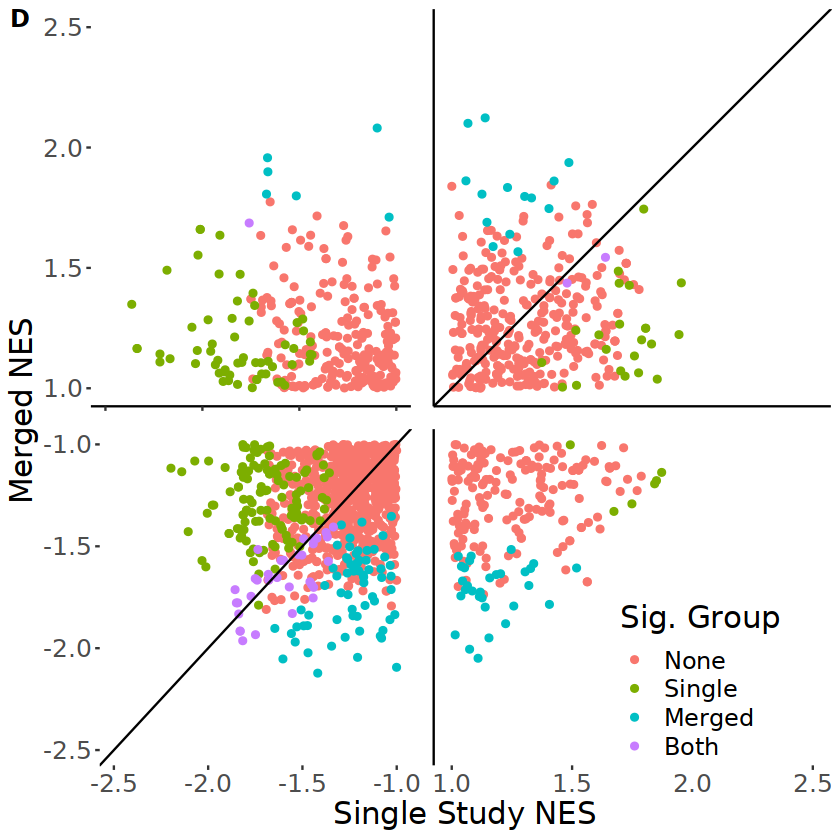

In [7]:
p1 <- merged_df %>% 
arrange(`Sig. Group`) %>% 
dplyr::mutate(`Sig. Group`=factor(`Sig. Group`, levels=c('None', 'Single', 'Merged', 'Both'))) %>%
arrange(match(`Sig. Group`, c('None', 'Single', 'Merged', 'Both'))) %>%
ggplot(aes(x=NES.y, y=NES.x, color=`Sig. Group`)) +
    geom_point(show.legend = FALSE) +
    geom_abline(slope=1,intercept=0) + 
    ylim(1,2.5) +
    xlim(1,2.5)

p2 <- merged_df %>% 
arrange(`Sig. Group`) %>% 
dplyr::mutate(`Sig. Group`=factor(`Sig. Group`, levels=c('None', 'Single', 'Merged', 'Both'))) %>%
arrange(match(`Sig. Group`, c('None', 'Single', 'Merged', 'Both'))) %>%
ggplot(aes(x=NES.y, y=NES.x, color=`Sig. Group`)) +
    geom_point() + xlab('Single Study NES') +
    ylim(-2.5, -1) +
    xlim(1,2.5)

p3 <- merged_df %>% 
arrange(`Sig. Group`) %>% 
dplyr::mutate(`Sig. Group`=factor(`Sig. Group`, levels=c('None', 'Single', 'Merged', 'Both'))) %>%
arrange(match(`Sig. Group`, c('None', 'Single', 'Merged', 'Both'))) %>%
ggplot(aes(x=NES.y, y=NES.x, color=`Sig. Group`)) +
    geom_point(show.legend = FALSE) + ylab('') +
    ylim(1,2.5) +
    xlim(-2.5,-1)

p4 <- merged_df %>% 
arrange(`Sig. Group`) %>% 
dplyr::mutate(`Sig. Group`=factor(`Sig. Group`, levels=c('None', 'Single', 'Merged', 'Both'))) %>%
arrange(match(`Sig. Group`, c('None', 'Single', 'Merged', 'Both'))) %>%
ggplot(aes(x=NES.y, y=NES.x, color=`Sig. Group`)) +
    geom_point(show.legend = FALSE) + xlab('') + ylab('Merged NES') + 
    geom_abline(slope=1,intercept=0) + 
    ylim(-2.5,-1) +
    xlim(-2.5,-1)

cowplot::plot_grid(p3 + theme_classic() + theme(text = element_text(size = 18), axis.line.y = element_blank(), axis.text.x = element_blank(),
                                    axis.title.x = element_blank()), 
                   p1 + theme_classic() + theme(text = element_text(size = 18),axis.text.y = element_blank(),
                                    axis.ticks.y = element_blank(),
                                    axis.title.y = element_blank(),
                                    axis.text.x = element_blank(),
                                    axis.ticks.x = element_blank(),
                                    axis.title.x = element_blank() ), 
                   p4 + theme_classic() + theme(text = element_text(size = 18),
                                                axis.line = element_blank(),
                                               axis.title.y = element_text(hjust=1.75)) ,
                   p2 + theme_classic() + theme(text = element_text(size = 18),axis.line.x = element_blank(), axis.text.y = element_blank(),
                                    axis.ticks.y = element_blank(),
                                    axis.title.y = element_blank(),
                                    axis.title.x = element_text(hjust=-0.75),
                                    legend.position = c(0.65, 0.25),
                                    legend.text=element_text(size=14)),
                   nrow = 2,
                   labels = c('D', '', '', '', ''))

In [8]:
# merged_df %>% dplyr::group_by(`Sig. Group`) %>% dplyr::summarize(counts=n())

In [9]:
group_list <- c('Single', 'Merged')
for (i in 1:2) {
    enrichment_df <- merged_df %>% dplyr::select(c('ID', 'Description.x', 'core_enrichment.x', 'core_enrichment.y', 'Sig. Group')) %>% dplyr::mutate(merged_genes=core_enrichment.x, single_genes=core_enrichment.y) 
    if (group_list[i] == 'Single') {
        entrez_list <- enrichment_df %>% dplyr::filter(`Sig. Group` == group_list[i]) %>% dplyr::select(core_enrichment.y) %>% deframe() %>% str_split("/")
    } else if (group_list[i] == 'Merged'){
        entrez_list <- enrichment_df %>% dplyr::filter(`Sig. Group` == group_list[i]) %>% dplyr::select(core_enrichment.x) %>% deframe() %>% str_split("/")
    }
    flattened_entrez_list <- entrez_list %>% unlist()
    # flattened_entrez_list

    entrez_counts <- flattened_entrez_list %>% 
                    enframe(value="ENTREZID") %>% 
                    dplyr::select("ENTREZID") %>% 
                    dplyr::group_by(ENTREZID) %>% 
                    dplyr::summarise(n=n()) %>%
                    dplyr::arrange(desc(n))

    entrez_counts$ENSEMBLID <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "ENSEMBL", multiVals = "first")
    entrez_counts$SYMBOL <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "SYMBOL", multiVals = "first")
}


'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [11]:
#merged_df %>% dplyr::select(c('ID', 'Description.x', 'Sig. Group')) %>% dplyr::filter(`Sig. Group` != 'None') 

# Genetic Backround Comparison

[Quick Links](#Quick-links)

In [12]:
entrez_list <- merged_df %>% dplyr::filter(`Sig. Group` == 'Merged') %>% dplyr::select(core_enrichment.y) %>% deframe() %>% str_split("/")
flattened_entrez_list <- entrez_list %>% unlist()


In [13]:
entrez_counts <- flattened_entrez_list %>% 
                enframe(value="ENTREZID") %>% 
                dplyr::select("ENTREZID") %>% 
                dplyr::group_by(ENTREZID) %>% 
                dplyr::summarise(n=n()) %>%
                dplyr::arrange(desc(n))

entrez_counts$ENSEMBLID <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "ENSEMBL", multiVals = "first")
entrez_counts$SYMBOL <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "SYMBOL", multiVals = "first")

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [14]:
strain_gene_list = c('ENSMUSG00000012819', # CDH23 Balb/c & C57BL (not in prefiltered, but assayed)
                   'ENSMUSG00000000386', # Mx1 Balb/c & C57BL (not in prefiltered, but assayed)
                     'ENSMUSG00000024248', #Cox7a2l Balb/c & C57BL (in prefiltered)
                     'ENSMUSG00000060802', #B2m Balb/c & C57BL (in prefiltered)
                     'ENSMUSG00000029468', # P2rx7 C57BL (in prefiltered)
                     'ENSMUSG00000019256', #Ahr C57BL (in prefiiltered)
                     'ENSMUSG00000025453', #Nnt C57BL (in prefiltered)
                     'ENSMUSG00000078817', # Nlrp12 C57BL (in prefiltered)
                     'ENSMUSG00000009585', #Apobec3 C57BL (in prefiltered)
                     'ENSMUSG00000024669', #Cd5 C57BL (in prefiltered)
                     'ENSMUSG00000020804', #Aanat C57BL (not in prefiltered)
                     'ENSMUSG00000000560', #Gabra2 C57BL (not in prefiltered)
                     'ENSMUSG00000023262', #Acy1 Balbc (in prefiltered)
                     'ENSMUSG00000028393', #Alad Balbc (in prefiltered)
                     ''
                   ) 

strain_symbol_list = c('Cdh23', # CDH23 Balb/c & C57BL (not in prefiltered, but assayed)
                   'Mx1', # Mx1 Balb/c (not in prefiltered, but assayed)
                     'Cox7a2l', #Cox7a2l Balb/c (in prefiltered)
                     'B2m', #B2m Balb/c (in prefiltered)
                     'P2rx7', # P2rx7 C57BL (in prefiltered)
                     'Ahr', #Ahr C57BL (in prefiiltered)
                     'Nnt', #Nnt C57BL (in prefiltered)
                     'Nlrp12', # Nlrp12 C57BL (in prefiltered)
                     'Apobec3', #Apobec3 C57BL (in prefiltered)
                     'Cd5', #CD5 C57BL (in prefiltered)
                     'Aanat', #Aanat C57BL (not in prefiltered)
                     'Gabra2', #Gabra2 C57BL (not in prefiltered)
                     'Acy1', #Acy1 Balbc (in prefiltered)
                     'Alad', #Alad Balbc (in prefiltered)
                     ''
                   ) 

nafld_symbol_list <- c('PNPLA3', 'TM6SF2', 'MBOAT7', 'GCKR', 'HSD17B13')

entrez_counts %>% dplyr::filter(ENSEMBLID %in% strain_gene_list)
entrez_counts %>% dplyr::filter(SYMBOL %in% strain_symbol_list)
entrez_counts %>% dplyr::filter(SYMBOL %in% nafld_symbol_list)

ENTREZID,n,ENSEMBLID,SYMBOL
<chr>,<int>,<chr>,<chr>
11622,9,ENSMUSG00000019256,Ahr
12507,2,ENSMUSG00000024669,Cd5


ENTREZID,n,ENSEMBLID,SYMBOL
<chr>,<int>,<chr>,<chr>
11622,9,ENSMUSG00000019256,Ahr
12507,2,ENSMUSG00000024669,Cd5


ENTREZID,n,ENSEMBLID,SYMBOL
<chr>,<int>,<chr>,<chr>


# SVM Only - Contributing Genes Comparison

In [15]:
svm_high_pval_df <- read.table(paste0("./data/go_bp_comparison_results/svm_gseGO_high_pval.tsv"), sep="\t", header = T)

In [16]:
#valid_id <- c('GO:0032946', 'GO:0002347', 'GO:0002834', 'GO:0002837', 'GO:0002418', 'GO:0006261', 'GO:0051346', 'GO:0010951', 'GO:0022408', 'GO:0007600', 'GO:0045346', 'GO:0007162', 'GO:0052646', 'GO:0031649', 'GO:0003009', 'GO:0045342', 'GO:0098659', 'GO:0099587', 'GO:0006953', 'GO:0051875', 'GO:0019233', 'GO:0002440', 'GO:0032400', 'GO:0031294', 'GO:0000727', 'GO:0018095', 'GO:0033619', 'GO:0050663', 'GO:0006270', 'GO:0006271', 'GO:0006268', 'GO:0018200', 'GO:0023061', 'GO:0007611', 'GO:0050731', 'GO:0031295', 'GO:0042730', 'GO:0042060', 'GO:0050920', 'GO:2000514', 'GO:0070664', 'GO:0099537', 'GO:0006638', 'GO:0021694', 'GO:0003013', 'GO:0008015', 'GO:0045785', 'GO:0050879', 'GO:0050881', 'GO:0001660', 'GO:0006639', 'GO:0007379', 'GO:0050672', 'GO:0007268', 'GO:0098916', 'GO:0048305', 'GO:0002790', 'GO:0007601', 'GO:0006829', 'GO:0032401', 'GO:0045214', 'GO:0002369', 'GO:0002724', 'GO:0016579', 'GO:2000379', 'GO:0035592', 'GO:2000311', 'GO:0002700', 'GO:0009306', 'GO:0050707', 'GO:0050435', 'GO:0071692', 'GO:0009611', 'GO:0050890', 'GO:0006023', 'GO:0021692', 'GO:0035825', 'GO:0000076', 'GO:0051905', 'GO:2000516', 'GO:0051952', 'GO:0060338', 'GO:0099054', 'GO:0002285', 'GO:0089718', 'GO:0015837', 'GO:0044786', 'GO:0007131', 'GO:0036037', 'GO:1901077', 'GO:0046339', 'GO:0046641', 'GO:1903510', 'GO:0050921', 'GO:0072511', 'GO:0030239', 'GO:0006022', 'GO:0043405', 'GO:0018108', 'GO:0006120', 'GO:0032402', 'GO:0002710')
valid_id <- c('GO:0002526',  'GO:0006261',  'GO:0022408',  'GO:0007162',  'GO:0045342',  'GO:0003009',  'GO:0010951',  'GO:0019884',  'GO:0045346',  'GO:0000727',  'GO:0031294',  'GO:0009101',  'GO:0098659',  'GO:0099587',  'GO:0006271',  'GO:0007600',  'GO:0006268',  'GO:0032400',  'GO:0048305',  'GO:0023061',  'GO:0018200',  'GO:0007611',  'GO:0033619',  'GO:0051875',  'GO:0002440',  'GO:0050920',  'GO:0031295',  'GO:0050879',  'GO:0050881',  'GO:0018095',  'GO:0099537',  'GO:0006270',  'GO:0019233',  'GO:0052646',  'GO:0031649',  'GO:0050663',  'GO:0002827',  'GO:2000514',  'GO:0032946',  'GO:0042060',  'GO:0007268',  'GO:0098916',  'GO:0060055',  'GO:0046640',  'GO:0045620',  'GO:0050890',  'GO:0006022',  'GO:0045785',  'GO:1903510',  'GO:0050731',  'GO:0045214',  'GO:0002347',  'GO:0032633',  'GO:0006023',  'GO:0021694',  'GO:0007379',  'GO:1901890',  'GO:0030203',  'GO:0035592',  'GO:1901077',  'GO:0002286',  'GO:0002418',  'GO:0032401',  'GO:0043370',  'GO:0006120',  'GO:0050921',  'GO:0060338',  'GO:0007613',  'GO:0045907',  'GO:0043501',  'GO:0051905',  'GO:0006638',  'GO:0006639',  'GO:0008015',  'GO:0001660',  'GO:0007601',  'GO:0032945',  'GO:2000516',  'GO:0009611',  'GO:0006953',  'GO:0021692',  'GO:0071692',  'GO:0030239',  'GO:0032402',  'GO:0055001',  'GO:0002834',  'GO:0002837',  'GO:0002790',  'GO:0099054',  'GO:2000379',  'GO:0060009',  'GO:0050707',  'GO:0043405',  'GO:0099177',  'GO:0061383',  'GO:0035994',  'GO:0007610')

In [17]:
filtered_svm_df <- svm_high_pval_df[,c('ID', 'Description', 'core_enrichment')] %>% dplyr::filter(ID %in% valid_id)

entrez_list <- filtered_svm_df$core_enrichment %>% str_split("/")
flattened_entrez_list <- entrez_list %>% unlist()

In [18]:
# extracting unique set of entrezids
entrez_counts <- flattened_entrez_list %>% 
                enframe(value="ENTREZID") %>% 
                dplyr::select("ENTREZID") %>% 
                dplyr::group_by(ENTREZID) %>% 
                dplyr::summarise(n=n()) %>%
                dplyr::arrange(desc(n))

entrez_overlaps <- entrez_counts %>% dplyr::filter(n>=15) %>% dplyr::select(ENTREZID)
entrez_list_tibble <- entrez_list %>% enframe(value='entrez_gene_list') %>% dplyr::mutate(contains_top_genes = '')

for (i in 1:97) { 
    intersects <- intersect(unlist(entrez_list[i]), entrez_overlaps$ENTREZID)
    # print(paste(i, as.list(intersects)))
    if (length(intersects) > 0) {
        entrez_list_tibble[i,3] <- paste(intersects, collapse=',')
    }   
}

entrez_counts$ENSEMBLID <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "ENSEMBL", multiVals = "first")
entrez_counts$SYMBOL <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "SYMBOL", multiVals = "first")

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [19]:
gene_list <- c('ENSMUSG00000032085','ENSMUSG00000026547','ENSMUSG00000019997','ENSMUSG00000045994','ENSMUSG00000030067','ENSMUSG00000021356','ENSMUSG00000057098','ENSMUSG00000068105','ENSMUSG00000024353','ENSMUSG00000003379','ENSMUSG00000032053','ENSMUSG00000040592','ENSMUSG00000041538','ENSMUSG00000030724','ENSMUSG00000024673','ENSMUSG00000026814','ENSMUSG00000020911','ENSMUSG00000000567','ENSMUSG00000023039','ENSMUSG00000045394','ENSMUSG00000066108','ENSMUSG00000029371','ENSMUSG00000026417','ENSMUSG00000037025','ENSMUSG00000045382','ENSMUSG00000059552','ENSMUSG00000024182','ENSMUSG00000000303','ENSMUSG00000026728','ENSMUSG00000026193','ENSMUSG00000037405','ENSMUSG00000029086','ENSMUSG00000035783','ENSMUSG00000001506','ENSMUSG00000021680','ENSMUSG00000021944','ENSMUSG00000040856','ENSMUSG00000054932','ENSMUSG00000029368','ENSMUSG00000059481','ENSMUSG00000019987','ENSMUSG00000025991','ENSMUSG00000022149','ENSMUSG00000074768','ENSMUSG00000076441','ENSMUSG00000017950','ENSMUSG00000024391','ENSMUSG00000050445','ENSMUSG00000032310','ENSMUSG00000026395','ENSMUSG00000026285','ENSMUSG00000016496','ENSMUSG00000031447','ENSMUSG00000039542','ENSMUSG00000002033','ENSMUSG00000023274','ENSMUSG00000053977','ENSMUSG00000053044','ENSMUSG00000051439','ENSMUSG00000018774','ENSMUSG00000008845','ENSMUSG00000030786','ENSMUSG00000025498','ENSMUSG00000024621','ENSMUSG00000024401','ENSMUSG00000020717','ENSMUSG00000002944','ENSMUSG00000006932','ENSMUSG00000028583','ENSMUSG00000024406','ENSMUSG00000031004','ENSMUSG00000027342','ENSMUSG00000041431','ENSMUSG00000020914','ENSMUSG00000020330','ENSMUSG00000019929','ENSMUSG00000028003','ENSMUSG00000047880','ENSMUSG00000025929','ENSMUSG00000002603','ENSMUSG00000026923','ENSMUSG00000030093','ENSMUSG00000039521','ENSMUSG00000026011','ENSMUSG00000025407','ENSMUSG00000023951','ENSMUSG00000022528','ENSMUSG00000048001','ENSMUSG00000040289','ENSMUSG00000027276','ENSMUSG00000022419','ENSMUSG00000002769','ENSMUSG00000021901','ENSMUSG00000025950','ENSMUSG00000030541','ENSMUSG00000040054','ENSMUSG00000022105','ENSMUSG00000036309','ENSMUSG00000070473','ENSMUSG00000001761','ENSMUSG00000002633')
entrez_counts %>% dplyr::filter(ENSEMBLID %in% gene_list)

ENTREZID,n,ENSEMBLID,SYMBOL
<chr>,<int>,<chr>,<chr>
21803,24,ENSMUSG00000002603,Tgfb1
60533,13,ENSMUSG00000016496,Cd274
12767,8,ENSMUSG00000045382,Cxcr4
14268,7,ENSMUSG00000026193,Fn1
18815,7,ENSMUSG00000059481,Plg
12842,6,ENSMUSG00000001506,Col1a1
19264,6,ENSMUSG00000026395,Ptprc
20423,5,ENSMUSG00000002633,Shh
11846,4,ENSMUSG00000019987,Arg1


# RR - Single & Merged Study Only Contributing Genes to GO BPs

[Quick Links](#Quick-links)

In [20]:
study_list <- list(rr1=list(), rr6=list(), rr8=list(), rr9=list())
merged_list <- list(rr1=list(), rr6=list(), rr8=list(), rr9=list())

In [21]:
# rr_dataset <- rr1_casis_high_pval_df
# rr_dataset <- rr3_high_pval_df
study <- 'RR1_NASA'
study <- 'RR6'
study <- 'RR8'
study <- 'RR9'

if(study == 'RR1_NASA') {
    rr_dataset <- rr1_nasa_high_pval_df
} else if(study == 'RR6') {
    rr_dataset <- rr6_high_pval_df
} else if(study == 'RR8') {
    rr_dataset <- rr8_high_pval_df
} else if(study == 'RR9') {
    rr_dataset <- rr9_high_pval_df
} 
    
threshold=5

merged_df <- dplyr::inner_join(x=svm_high_pval_df, y=rr_dataset, by = 'ID') %>% 
dplyr::select(c('ID', 'Description.x', 'NES.x', 'p.adjust.x', 'NES.y', 'p.adjust.y', 'core_enrichment.x', 'core_enrichment.y')) %>%
dplyr::mutate(
    merged_significant=p.adjust.x <= 0.1, 
    single_significant=p.adjust.y <= 0.1
) %>%
dplyr::mutate(
    both_significant = merged_significant * single_significant == TRUE,
    both_not_significant = (merged_significant == FALSE) & (single_significant == FALSE) & (merged_significant * single_significant == FALSE),
    merged_only = merged_significant == TRUE & single_significant == FALSE &  merged_significant * single_significant == FALSE,
    single_only = merged_significant == FALSE & single_significant == TRUE &  merged_significant * single_significant == FALSE    
) %>%
dplyr::mutate(
    `Sig. Group` = ifelse(both_significant, 'Both', ifelse(both_not_significant, 'None', ifelse(merged_only, 'Merged', 'Single')))
) %>% 
dplyr::rename(
    svm_genes = 'core_enrichment.x',
    dge_genes = 'core_enrichment.y'
)


In [22]:
entrez_list <- merged_df %>% dplyr::filter(`Sig. Group` == 'Single') %>% dplyr::select(dge_genes) %>% stringr::str_split("/")
merged_entrez_list <- merged_df %>% dplyr::filter(`Sig. Group` == 'Merged') %>% dplyr::select(svm_genes) %>% stringr::str_split("/")

flattened_entrez_list <- entrez_list %>% unlist() %>% gsub('[^[:alnum:] ]', '', .) %>% gsub('[c]', '', .) %>% stringr::str_split(" ") %>% unlist()
merged_flattened_entrez_list <- merged_entrez_list %>% unlist() %>% gsub('[^[:alnum:] ]', '', .) %>% gsub('[c]', '', .) %>% stringr::str_split(" ") %>% unlist()


entrez_counts <- flattened_entrez_list %>% 
                enframe(value="ENTREZID") %>% 
                dplyr::select("ENTREZID") %>% 
                dplyr::group_by(ENTREZID) %>% 
                dplyr::summarise(n=n()) %>%
                dplyr::arrange(desc(n))

merged_entrez_counts <- merged_flattened_entrez_list %>% 
                enframe(value="ENTREZID") %>% 
                dplyr::select("ENTREZID") %>% 
                dplyr::group_by(ENTREZID) %>% 
                dplyr::summarise(n=n()) %>%
                dplyr::arrange(desc(n))

# entrez_overlaps <- entrez_counts %>% dplyr::filter(n>=15) %>% dplyr::select(ENTREZID)

entrez_counts$ENSEMBLID <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "ENSEMBL", multiVals = "first")
entrez_counts$SYMBOL <- mapIds(org.Mm.eg.db,keys = entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "SYMBOL", multiVals = "first")

merged_entrez_counts$ENSEMBLID <- mapIds(org.Mm.eg.db,keys = merged_entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "ENSEMBL", multiVals = "first")
merged_entrez_counts$SYMBOL <- mapIds(org.Mm.eg.db,keys = merged_entrez_counts$ENTREZID ,keytype = "ENTREZID", column = "SYMBOL", multiVals = "first")

Warning message in stri_split_regex(string, pattern, n = n, simplify = simplify, :
“argument is not an atomic vector; coercing”
Warning message in stri_split_regex(string, pattern, n = n, simplify = simplify, :
“argument is not an atomic vector; coercing”
'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

